In [1]:
from vis import *
from landmarks import *
from variations import *
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
visualise_canal_mesh(9, "posterior")

In [ ]:
# visualise_canal_planes(range(1, 25), "lateral")
visualise_subject_planes(2) 

### Slider and GUI experiments

In [2]:
visualise_variation_modes(1, "posterior")

In [ ]:
subject = 9
canal = "posterior"

v, t = get_canal_mesh(subject, canal)
canal_mesh = o3d.geometry.TriangleMesh()
canal_mesh.vertices = o3d.utility.Vector3dVector(v)
canal_mesh.triangles = o3d.utility.Vector3iVector(t)
canal_mesh.compute_vertex_normals()
canal_mesh.paint_uniform_color([0.49019608, 0.51764706, 1]) 

def screenshot(vis):
    vis.capture_screen_image("subject {} {}.png".format(subject, canal), do_render=False)

def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(10.0, 0.0)
    return False

vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()
vis.add_geometry(canal_mesh)
vis.get_render_option().mesh_show_back_face = True
vis.register_animation_callback(rotate_view)
# vis.register_key_callback(ord("W"), screenshot)
# vis.set_full_screen(True)

vis.run()
vis.destroy_window()

### Horn's analysis

In [ ]:
canal = "anterior"
rd2, fd2, vd2 = load_fiducials_dicts(visible=True)
vertices, t = get_canal_mesh(right[0], canal)
sample_cov = np.zeros((len(vertices)*3, len(vertices)*3))
# for subject in right:
#     vertices, t = get_canal_mesh(subject, canal)
#     vertices -= np.mean(vertices, axis=0)
#     vertices = rotate_vertices(vertices, get_rotation_matrix(subject, get_landmarks_from_key(fd2[canal])))
#     vertices = vertices.reshape(vertices.shape[0] * 3)
#     sample_cov += np.outer(vertices, vertices)

p = len(right)
N = len(right)
B = 300

evals_matrix = []
for b in range(B):
    sample_cov = np.zeros((p, p))
    for n in range(N):
        x = np.random.normal(0, 1, p)   
        sample_cov += np.outer(x, x)
    sample_cov /= N - 1
    corr = get_correlation_from_covariance(sample_cov)
    evals, evecs = np.linalg.eigh(sample_cov)
    evals_matrix.append(evals)

evals_matrix = np.array(evals_matrix)
thresholds = np.percentile(evals_matrix, 95, axis=0)
thresholds[-20:]

In [ ]:
canal = "anterior"
rd2, fd2, vd2 = load_fiducials_dicts(visible=True)
vertices, t = get_canal_mesh(right[0], canal)
sample_cov = np.zeros((len(vertices)*3, len(vertices)*3))
mean_vertices = np.zeros(len(vertices)*3)
for subject in right:
    vertices, t = get_canal_mesh(subject, canal)
    rotation = get_rotation_matrix(subject, get_landmarks_from_key(fd2[canal]))
    vertices = rotate_vertices(vertices-np.mean(vertices, axis=0), rotation)
    mean_vertices += vertices.reshape(vertices.shape[0] * 3)
mean_vertices /= len(right)
for subject in right:
    vertices, t = get_canal_mesh(subject, canal)
    rotation = get_rotation_matrix(subject, get_landmarks_from_key(fd2[canal]))
    vertices = rotate_vertices(vertices-np.mean(vertices, axis=0), rotation)
    vertices = vertices.reshape(vertices.shape[0] * 3)
    sample_cov += np.outer(vertices - mean_vertices, vertices - mean_vertices)
sample_cov /= len(right) - 1
evals, evecs = np.linalg.eigh(get_correlation_from_covariance(sample_cov))

### Rewrite the fiducial ranking

In [3]:
results_dict, best_fids_dict, min_angs_dict, max_improvs_dict, kept_dict = load_fiducials_dicts(True)
len(results_dict)

414

### Plane fit evaluation

In [7]:
evs = np.zeros((3, 3, len(right)))
canals = ["posterior", "anterior", "lateral"]
for c, canal in enumerate(canals):
    for s, subject in enumerate(right):
        vals, vecs, vertices = get_canal_plane(subject, canal)
        evs[c, :, s] = vals

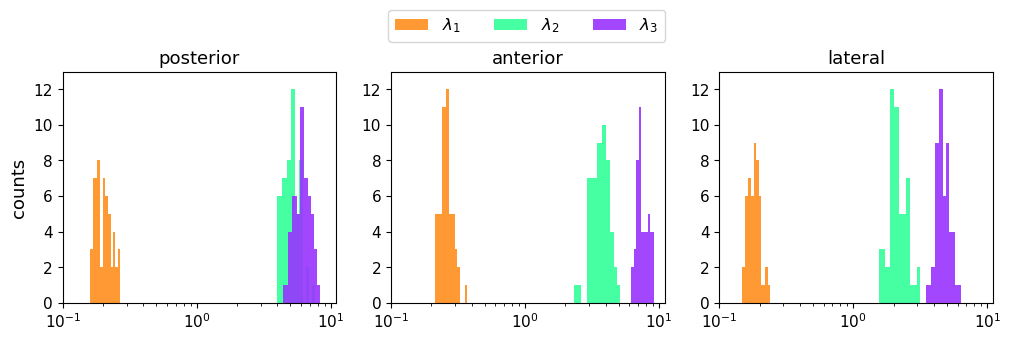

In [8]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
colors = [[1, 0.6, 0.2], [0.2, 1, 0.6], [0.6, 0.2, 1]]
for c, canal in enumerate(canals):
    axs[c].hist(evs[c, 0], color = colors[0], bins=11, label="$\lambda_1$")
    axs[c].hist(evs[c, 1], color = colors[1], alpha=0.9, label="$\lambda_2$")
    axs[c].hist(evs[c, 2], color = colors[2], alpha=0.9, label="$\lambda_3$")
    axs[c].set_xscale('log')
    axs[c].set_title(canal, fontsize=13)
    axs[c].set_ylim((0, 13))
    axs[c].tick_params(labelsize=11)
    axs[c].set_xlim((0.1, 11))
    if c==0: axs[c].set_ylabel("counts", fontsize=13)
    # axs[c].set_xticks(np.arange(0, 10, 2))
    # axs[c].set_yticks(np.arange(-4, 6, 2))
plt.legend(loc=(-1.21, 1.13), ncol=3, fontsize=12)

In [109]:
for c, canal in enumerate(canals):
    print(canal, np.mean(evs[c, 1, :]/evs[c, 0, :]), np.mean(evs[c, 2, :]/evs[c, 0, :]), np.mean(evs[c, 2, :]/evs[c, 1, :]))

posterior 25.490313285188208 30.602208816085245 1.204284105444536
anterior 14.266345150385783 29.266518198365283 2.0682223737783576
lateral 12.064539560039027 26.11639608490594 2.188303079318611


In [137]:
R2s = np.zeros((3, len(right)))
for c, canal in enumerate(canals):
    for s, subject in enumerate(right):
        R2s[c, s] = 1 - evs[c, 0, s]/np.prod(evs[c, :, s])

In [139]:
print(np.mean(R2s, axis = 1), np.min(R2s, axis = 1), np.max(R2s, axis = 1), sep="\n")

[0.9676309  0.96348953 0.900747  ]
[0.94493024 0.93287673 0.82434199]
[0.984164   0.97768594 0.94961694]
